In [1]:
# Leon Grinshpun 316226679

# Imports
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import os

from scipy import ndimage
from pylab import *
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial

plt.rcParams["figure.figsize"] = (8,8)


### Q1-1

In [2]:
# Given parameters
mean = 10
std = 5

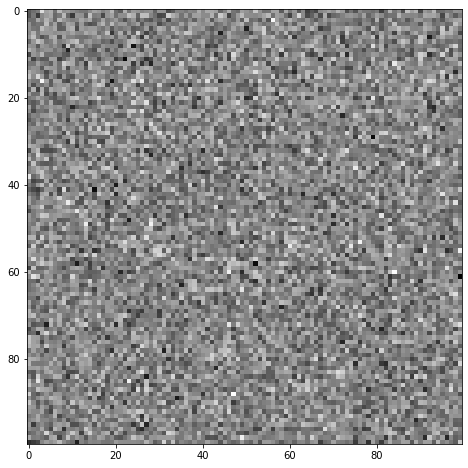

In [21]:
# Create the gaussian matrix with the given params
gaussian_mat = np.random.normal(mean, std, (100,100))
plt.imshow(gaussian_mat, cmap='gray')
plt.show()

### Q1-2

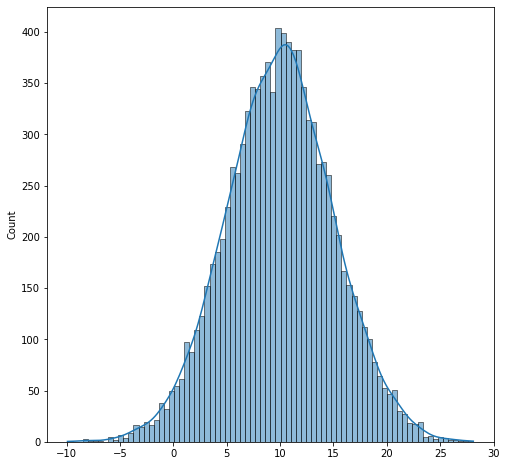

In [24]:
# Show histogram of the matrix from section a
sns.histplot(np.ravel(gaussian_mat),kde=True,bins=80)
plt.show()

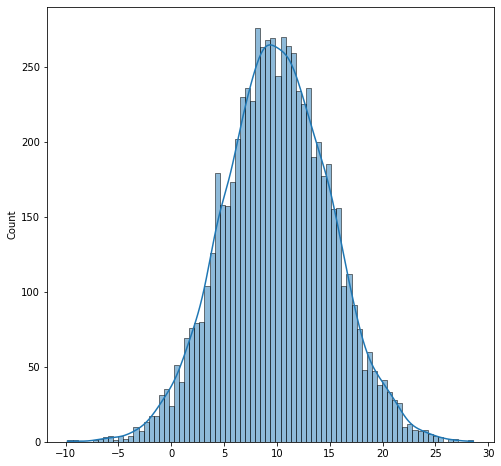

In [5]:
# Create different distribution function
diff_dist = np.random.choice(a = np.ravel(gaussian_mat), size = 7000, replace = False)
sns.histplot(diff_dist,kde=True,bins=80)
plt.show()


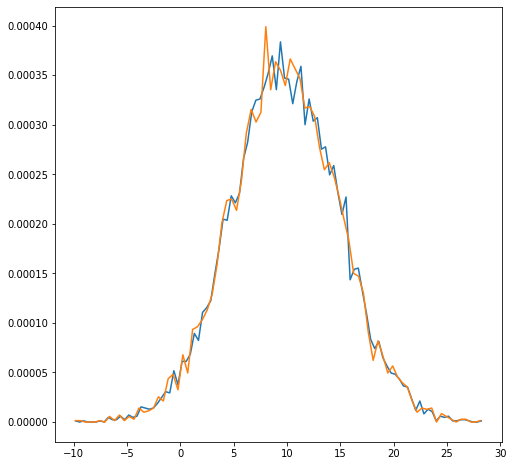

In [6]:
# Compare the two disributions:
gaussian_ravel = np.ravel(gaussian_mat)

#binning
nx, binsx = np.histogram(gaussian_ravel, bins = int(np.ceil(np.sqrt(gaussian_mat.size))))
ny, binsy = np.histogram(diff_dist, bins = int(np.ceil(np.sqrt(diff_dist.size))))


#normalizings
nx = nx/len(gaussian_ravel)/len(binsy)
ny = ny/len(diff_dist)/len(binsx)

#plotting
plt.plot(binsx[:-1],nx)
plt.plot(binsy[:-1],ny)
plt.show()

### Q1-3

In [7]:
# Read the RGB photo:
img = plt.imread('imgs/butterfly.jpg')

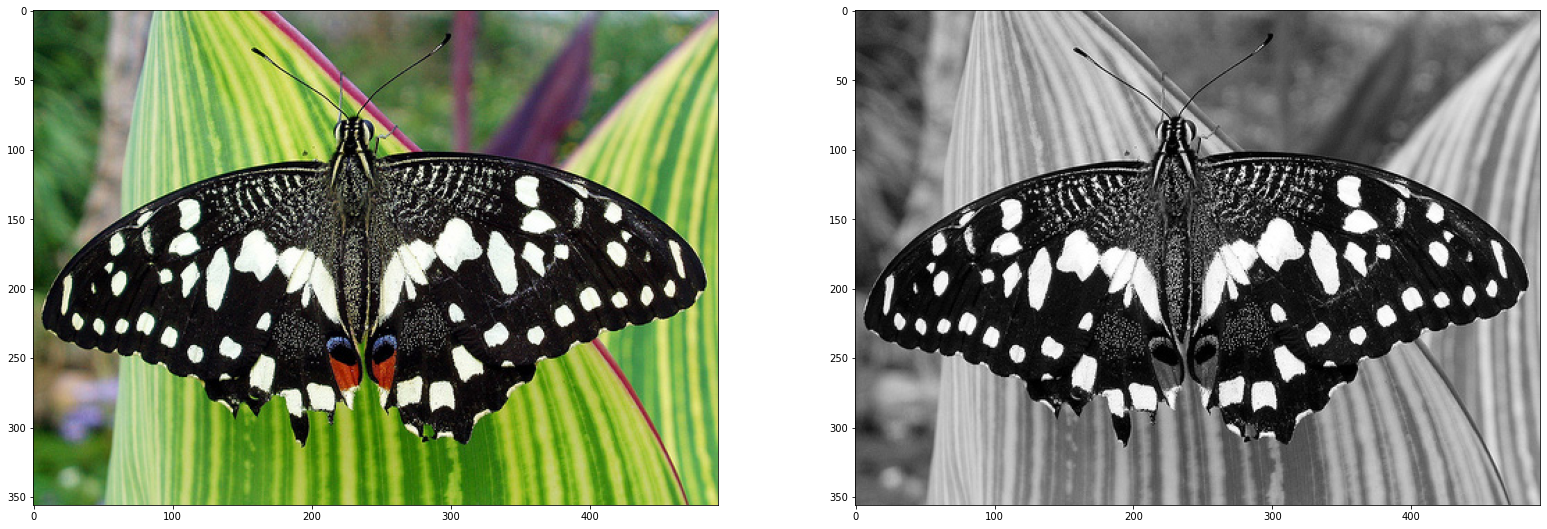

In [8]:
# Convert the photo to gray-scale
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1,2,figsize=(27, 27))
ax[0].imshow(img)
ax[1].imshow(img_gray, cmap = 'gray')
plt.show()

### Q1-4

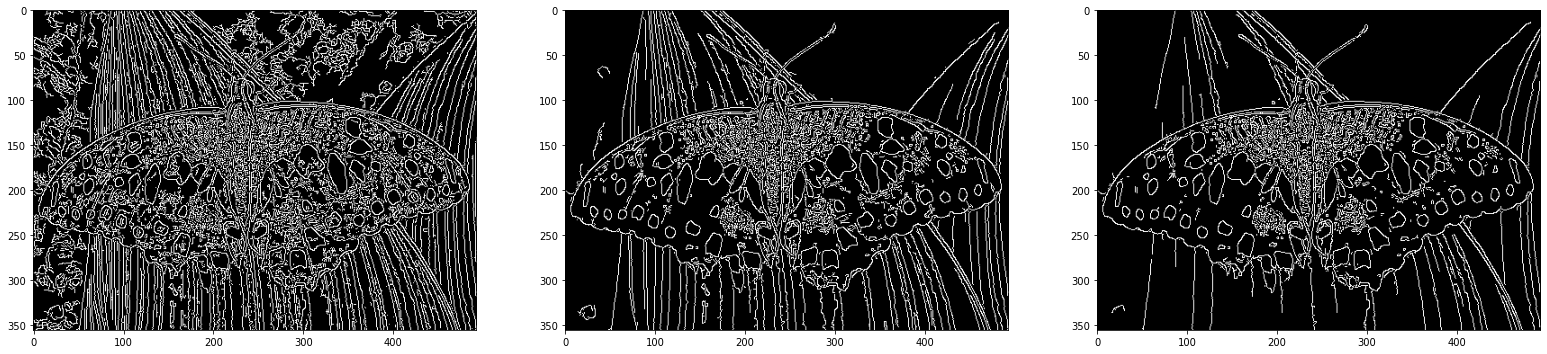

In [28]:
# Use Canny edge detector for gray image. Canny edge detection is a technique to extract useful structural information from different
# vision objects and dramatically reduce the amount of data to be processed

list_params = ((0,80),(50,180),(100,220))
list_images = list()
for i in range(3):
    list_images.append(cv2.Canny(img_gray,list_params[i][0],list_params[i][1]))

fig, ax = plt.subplots(1,3,figsize=(27, 27))
ax[0].imshow(list_images[0], cmap = 'gray')
ax[1].imshow(list_images[1], cmap = 'gray')
ax[2].imshow(list_images[2], cmap = 'gray')

plt.show()

### Q1-5

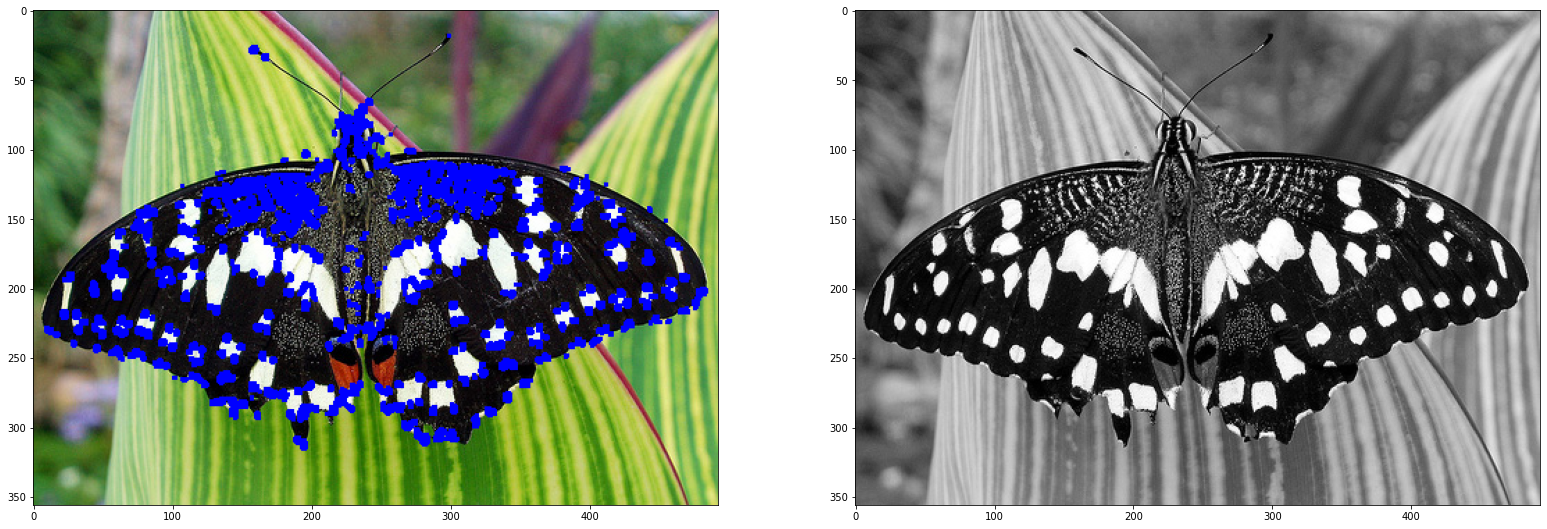

In [10]:
# The Harris corner detector is a corner detection operator.
# The idea behind the Harris method is to detect points based on the intensity variation in a local neighborhood.

list_params = ((2,3),(4,5))
img_gray_cornerHarris = np.float32(img_gray)
list_images = list()
for i in range(2):
    img = plt.imread('imgs/butterfly.jpg')
    img_cornerHarris = cv2.cornerHarris(img_gray_cornerHarris, list_params[i][0],list_params[i][1],0.04)
    
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(img_cornerHarris,None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()] = [0,0,255]
    list_images.append(img)
list_images = np.array(list_images)

fig, ax = plt.subplots(1,2,figsize=(27, 27))
ax[0].imshow(img)
ax[1].imshow(img_gray, cmap = 'gray')
plt.show()
    

# Q2 Blob detector

In [25]:
# Laplacian blob detector is used to convolve the image with a “blob filter” at multiple scales and look for extrema of filter response in the resulting scale space.
# Given parameters:
k = np.power(2.0, 0.25)
sigma = 2.0

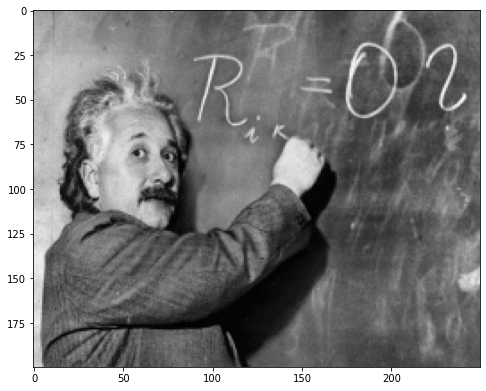

In [12]:
img = plt.imread('imgs/einstein.jpg')
img = cv2.resize(img,(250,200))
img_org = img.copy()
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) / 255.0 # normalaize the photo from 0-255 -> 0.0-1.0
plt.imshow(img,cmap='gray')
plt.show()

In [13]:
# Given LoG function:

def log_filt(ksize, sig):
    std2 = float( sig**2 )
    x = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    y = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    X, Y = np.meshgrid(x, y)
    arg = -(X*X + Y*Y)/(2*std2);
    
    h = np.exp(arg);
    eps = sys.float_info.epsilon
    h[h < eps*np.max(h)] = 0;
    
    sumh = np.sum(h)
    if sumh != 0:
       h  = h/sumh
       
       # now calculate Laplacian     
    h1 = h*(X*X + Y*Y - 2*std2)/(std2**2);
    h = h1 - np.sum(h1)/(ksize*ksize) # make the filter sum to zero
  
    return h

In [14]:
# Calculation with convolution with the set of filters

def LoG_convolve(img,num_of_levels):
    log_images = []
    for i in range(0,num_of_levels):
        y = np.power(k,i)
        sigma_1 = sigma*y
        filter_size = 2* np.ceil(3*sigma_1) + 1 # filter size
        filter_log = log_filt(filter_size,sigma_1) * (sigma_1**2) # We normalaze with sigma^2 for getting the right scale between 0-255.
        image = cv2.filter2D(img,-1,filter_log)
        image = np.pad(image,((1,1),(1,1)),'constant')
        image = np.square(image)
        log_images.append(image)
    log_image_np = np.array(log_images)
    return log_image_np

num_of_levels = 13
log_image_np = LoG_convolve(img,num_of_levels)

In [15]:
# Detect all the blobs in the photo:

def blob_detection(log_image_np,thr=0.03):
    coordinates = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2]
            result = np.amax(slice_img)
            result_1 = np.amin(slice_img)
            if result >= thr:
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                coordinates.append((i+x-1,j+y-1,k**z*sigma))
    return coordinates


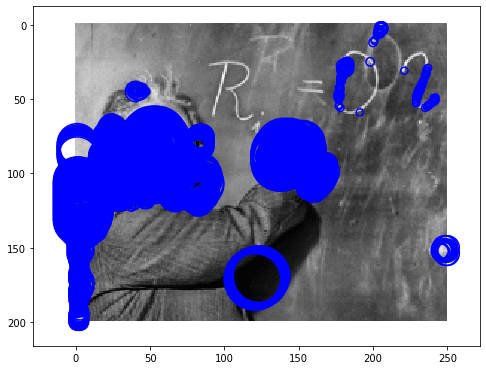

In [16]:
coordinates = list(set(blob_detection(log_image_np)))
coordinates = np.array(coordinates)

fig, ax = plt.subplots()
nh,nw = img.shape

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in coordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*k, color='blue', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

In [17]:
def clean_blob(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))

In [18]:
def reduce_blobs(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if clean_blob(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])


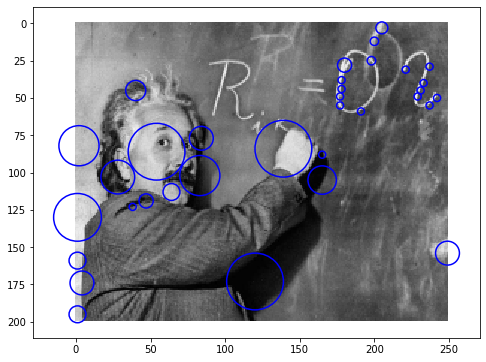

In [19]:
coordinates = reduce_blobs(coordinates,0.2)
fig, ax = plt.subplots()
nh,nw = img.shape

ax.imshow(img_org, interpolation='nearest',cmap="gray")
for blob in coordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*k, color='blue', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

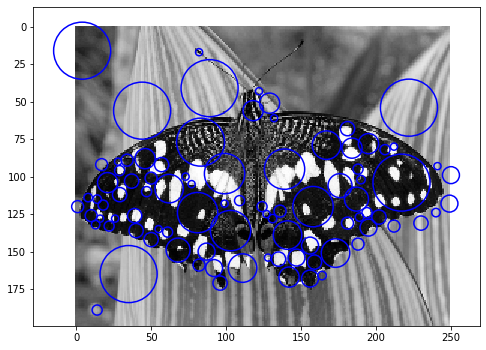

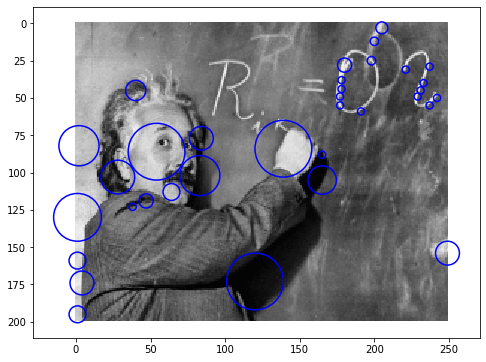

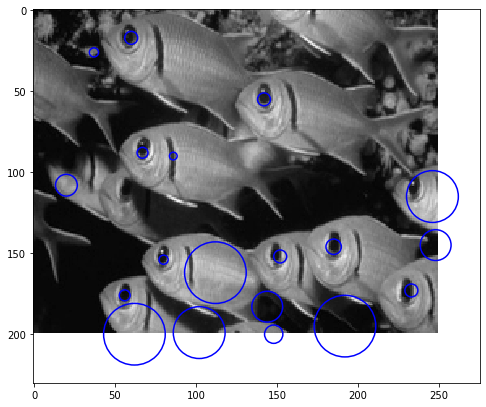

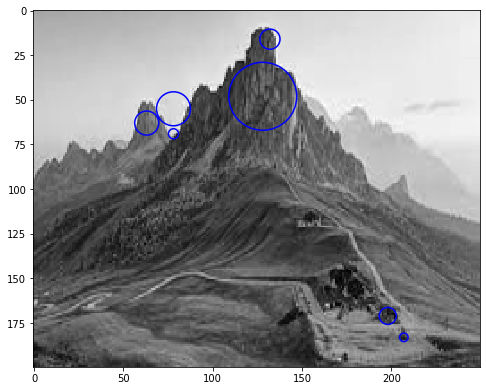

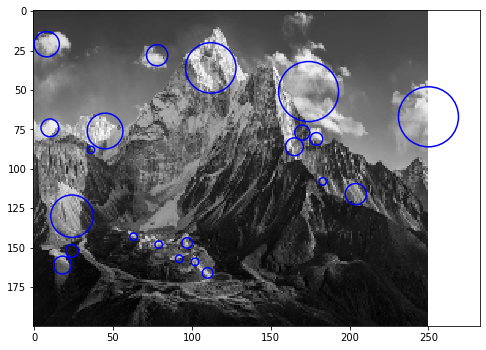

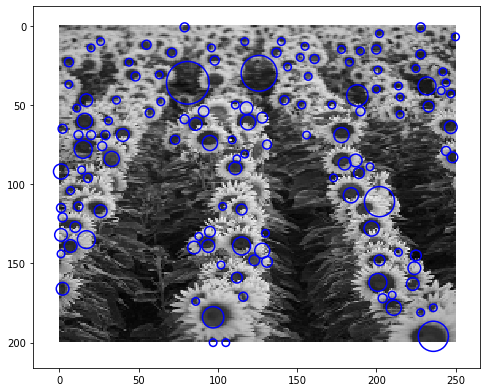

In [20]:
path = 'imgs/'
list_images_paths = [path+ name for name in os.listdir(path)]
list_images_paths

for img_path in list_images_paths:
    img = plt.imread(img_path)
    img = cv2.resize(img,(250,200))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) / 255.0 # normalaize the photo from 0-255 -> 0.0-1.0
    log_image_np = LoG_convolve(img,num_of_levels) # use blob
    
    coordinates = list(set(blob_detection(log_image_np)))
    coordinates = np.array(coordinates)
    coordinates = reduce_blobs(coordinates,0.2)

    fig, ax = plt.subplots()
    nh,nw = img.shape

    ax.imshow(img, interpolation='nearest',cmap="gray")
    for blob in coordinates:
        y,x,r = blob
        c = plt.Circle((x, y), r*k, color='blue', linewidth=1.5, fill=False)
        ax.add_patch(c)
        
    ax.plot()  
    plt.show()
